In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from pyproj import CRS

In [2]:
stock_data = pd.read_csv("Datasets/final_set.csv")

data = []

# and i[5] == "Quebec"

for i in stock_data.values:
    if i[8] == "Residential" and i[9] == "Flat":
        data.append(i)
df = pd.DataFrame(data)

df.columns = [
    "Municipality",
    "Latitude",
    "Longitude",
    "CGNDB ID",
    "Generic Term",
    "Province - Territory",
    "Nearest NSRDB latitude",
    "Nearest NSRDB longitude",
    "Array Type",
    "Market Pricing",
    "Tariff Applied",
    "First Yr Annual (MWh)",
    "First Yr Winter (MWh)",
    "First Yr Spring (MWh)",
    "First Yr Summer (MWh)",
    "First Yr Fall (MWh)",
    "Installation Cost Scenario",
    "Breakeven Price ($/MWh)",
    "Reference Price ($/MWh)",
    "Breakeven Price (¢/kWh)",
    "Reference Price (¢/kWh)",
    "Total Capacity (MW)",
    "Annual",
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December",
]

In [3]:
print(df)

        Municipality  Latitude  Longitude CGNDB ID             Generic Term  \
0     100 Mile House     51.64    -121.29    JCBMZ    District Municipality   
1     108 Mile Ranch     51.75    -121.35    JBHFG                Community   
2      70 Mile House     51.30    -121.40    JCCIT                Community   
3              Abbey     50.73    -108.75    HABJF                  Village   
4         Abbotsford     49.05    -122.32    JABNO                     City   
...              ...       ...        ...      ...                      ...   
4082       Zealandia     51.61    -107.74    HAVTP                     Town   
4083        Zeballos     49.98    -126.84    JBTDH                  Village   
4084      Zenon Park     53.06    -103.75    HAVTX                  Village   
4085          Zephyr     44.20     -79.26    FDGAU  Compact Rural Community   
4086          Zurich     43.42     -81.62    FDGCX                Community   

     Province - Territory  Nearest NSRDB latitude  

In [4]:
df_feats = df[["Latitude", "Longitude", "Total Capacity (MW)", "Annual", "First Yr Annual (MWh)"]]
df_labels = df[["Breakeven Price ($/MWh)"]]


In [5]:
rstate=4
tts=0.6

In [6]:
feats_train, feats_eval, labels_train, labels_eval = train_test_split(df_feats, df_labels, train_size=tts, random_state=rstate)

In [7]:
model = KNeighborsRegressor(weights="distance")
knn_grid = {"n_neighbors": np.arange(1, 21)}
model_knn = GridSearchCV(model, knn_grid, cv=9)
model_knn.fit(feats_train, labels_train)

print("Best K Value: ", model_knn.best_params_)
print("R^2 - Fit: ", model_knn.best_score_, "\n")



Best K Value:  {'n_neighbors': 6}
R^2 - Fit:  0.9016335117905511 



In [8]:
print(pd.DataFrame(model_knn.cv_results_))

    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.003225  4.159292e-04         0.001668    4.718013e-04   
1        0.003003  2.997109e-07         0.002002    2.085900e-07   
2        0.003225  4.160920e-04         0.001557    4.973538e-04   
3        0.002780  4.160849e-04         0.001891    3.144718e-04   
4        0.002780  4.160494e-04         0.001891    3.144530e-04   
5        0.002891  3.143780e-04         0.002002    4.717075e-04   
6        0.003114  3.144534e-04         0.002113    3.145936e-04   
7        0.003336  4.718950e-04         0.002336    4.715203e-04   
8        0.002891  5.670001e-04         0.002336    6.671217e-04   
9        0.002891  3.143968e-04         0.002225    4.161911e-04   
10       0.004448  6.856116e-04         0.003559    8.324601e-04   
11       0.004226  1.228152e-03         0.003114    7.376575e-04   
12       0.004226  6.289951e-04         0.003670    4.717452e-04   
13       0.003559  6.854268e-04         0.003225

In [9]:
output = model_knn.predict(feats_eval)
print("R^2 - Evaluation: ", r2_score(labels_eval, output))


R^2 - Evaluation:  0.9093167114304579


In [10]:
labels_eval = pd.DataFrame.to_numpy(labels_eval)

In [11]:
errors = []

#   mean_absolute_error()
#   mean_absolute_percentage_error()

for i in range(len(output)):
    errors.append(mean_absolute_percentage_error(labels_eval[i], output[i])*100)

errors = pd.DataFrame(errors)

In [12]:
print(mean_absolute_error(labels_eval, output))
print(mean_absolute_percentage_error(labels_eval, output))

1.9491856769909635
0.012260946311136346


In [13]:
print(labels_eval[0])

[143.64]


In [14]:
mapdata = feats_eval
prices = labels_eval

In [15]:
mapdata.insert(3, "Error", errors)
mapdata.insert(4, "BPrice", prices)

Text(0.5, 1.0, 'Error (percentage)')

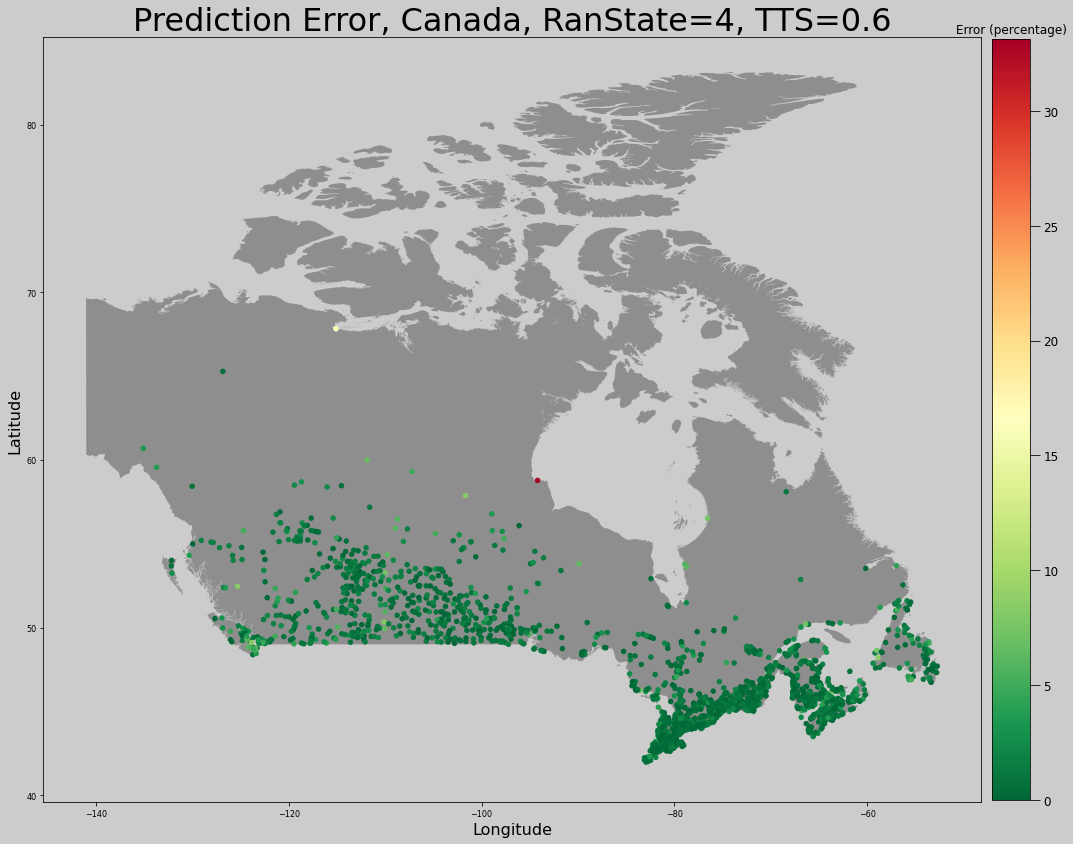

In [16]:
map = gpd.read_file("Shapefile/canada.shp")
fig, ax = plt.subplots(figsize=(20, 20))
crs = CRS("EPSG:4326")

geometry = [Point(xy) for xy in (zip(mapdata["Longitude"], mapdata["Latitude"]))]
geoframe = gpd.GeoDataFrame(mapdata, crs=crs, geometry=geometry)

geography = map.plot(ax=ax, alpha=0.3, color="black")
plt.title("Prediction Error, Canada, RanState=" + str(rstate) + ", TTS=" + str(tts), fontsize=32)
plt.xlabel("Longitude", fontsize=16)
plt.ylabel("Latitude", fontsize=16)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
fig.patch.set_facecolor((0.80, 0.80, 0.80))
ax.set_facecolor((0.80, 0.80, 0.80))

#   cmap="RdYlGn_r"
#   color="black"

plotpoints = geoframe.plot(ax=ax, markersize=20, column="Error", legend_kwds={"shrink": 0.7, "pad": 0.01}, legend=True, cmap="RdYlGn_r")

pointfig = plotpoints.figure
pointax = pointfig.axes[1]
pointax.tick_params(labelsize=12, length=10)
pointax.set_title("Error (percentage)")

